In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(palette="colorblind")

In [ ]:
# Default date ranges
from datetime import datetime

import pytz


DEFAULT_DATE_RANGES = (
    ('2019-05-01', '2019-08-31'),
    ('2019-09-01', '2019-12-31'),
    ('2020-02-01', '2020-05-31'),
    ('2021-05-01', '2021-08-31'),
)

# Mapping between name of default period to dates
DEFAULT_PERIOD_TO_RANGE = {
    'Summer 2019':         DEFAULT_DATE_RANGES[0],
    'Pre-COVID-19 Summer': DEFAULT_DATE_RANGES[0],
    'Fall 2019':           DEFAULT_DATE_RANGES[1],
    'Pre-COVID-19 Fall':   DEFAULT_DATE_RANGES[1],
    'Spring 2020':         DEFAULT_DATE_RANGES[2],
    'In-COVID-19':         DEFAULT_DATE_RANGES[2],
    'Summer 2021':         DEFAULT_DATE_RANGES[3],
    'Post-COVID-19':       DEFAULT_DATE_RANGES[3],
}

timezone = pytz.timezone('America/Los_Angeles')
summer2019 = (datetime(2019, 5, 1, tzinfo=timezone), datetime(2019, 8, 31, tzinfo=timezone))
fall2019 = (datetime(2019, 9, 1, tzinfo=timezone), datetime(2019, 12, 31, tzinfo=timezone))
spring2020 = (datetime(2020, 2, 1, tzinfo=timezone), datetime(2020, 5, 31, tzinfo=timezone))
summer2020 = (datetime(2020, 6, 1, tzinfo=timezone), datetime(2020, 8, 31, tzinfo=timezone))
fall2020 = (datetime(2020, 9, 1, tzinfo=timezone), datetime(2020, 12, 31, tzinfo=timezone))
summer2021 = (datetime(2021, 5, 1, tzinfo=timezone), datetime(2021, 8, 31, tzinfo=timezone))

In [ ]:
from gymportal.data import get_data, extract_training_data

def get_train(period):
    data = get_data('caltech', "DEMO_TOKEN", drop_columns=(), start=period[0], end=period[1])
    # data = data.dropna(subset=["userInputs"])
    data = data[data.connectionTime.dt.day == data.disconnectTime.dt.day]
    
    return extract_training_data(data)

In [ ]:
full = (datetime(2018, 3, 25, tzinfo=timezone), datetime(2021, 9, 13, tzinfo=timezone))
triple = (datetime(2018, 3, 25, tzinfo=timezone), datetime(2020, 5, 31, tzinfo=timezone))
# get_data('caltech', "DEMO_TOKEN", drop_columns=(), start=full[0], end=full[1])

In [ ]:
data = {
    "summer2019": get_train(summer2019),
    "fall2019": get_train(fall2019),
    "spring2020": get_train(spring2020),
    "summer2020": get_train(summer2020),
    "fall2020": get_train(fall2020),
    "summer2021": get_train(summer2021),
    "triple": get_train(triple),
    "full": get_train(full),
}

# data

In [ ]:
for key, value in data.items():
    print(f"{key}:{value.shape}")

In [ ]:
# fig = plt.figure(figsize=(10, 10))
# for i, (key, X_train) in enumerate(data.items(), start=1):
#     ax = fig.add_subplot(2, 2, i, projection='3d')
#     ax.set_title(key)
#     ax.set_xlabel("arrival")
#     ax.set_ylabel("duration")
#     ax.set_zlabel("demand")

#     ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], alpha=0.1)

In [ ]:
fig = plt.figure(figsize=(20, 15), tight_layout=True)
n_rows = len(data.items())

i = 1
for key, X_train in data.items():
    ax = fig.add_subplot(n_rows, 3, i)
    ax.set_title(key)
    ax.set_xlabel("arrival")
    ax.set_ylabel("duration")
    ax.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2)

    ax = fig.add_subplot(n_rows, 3, i + 1)
    ax.set_title(key)
    ax.set_xlabel("arrival")
    ax.set_ylabel("demand")
    ax.scatter(X_train[:, 0], X_train[:, 2], alpha=0.2)

    ax = fig.add_subplot(n_rows, 3, i + 2)
    ax.set_title(key)
    ax.set_xlabel("duration")
    ax.set_ylabel("demand")
    ax.scatter(X_train[:, 1], X_train[:, 2], alpha=0.2)

    i += 3

In [ ]:
sns.barplot(x=data.keys(), y=[len(X) for X in data.values()], palette="viridis")
plt.xticks(rotation=45)
pass

In [ ]:
for d in data.values():
    print(d.max(axis=0))

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

from src.utils import ManualMaxScaler


def get_gmm(X_train):
    # scaler = StandardScaler()
    scaler = ManualMaxScaler([24, 24, 80])
    X_train = scaler.fit_transform(X_train)

    gmm = BayesianGaussianMixture(n_components=50, n_init=20, max_iter=1000)

    gmm.fit(X_train)
    return gmm, scaler

In [12]:
import pickle

try:
    with open("gmms.pkl", "rb") as f:
        gmms = pickle.load(f)
except FileNotFoundError:
    gmms = {
        key: get_gmm(X_train) for key, X_train in data.items()
    }
    with open("gmms.pkl", "wb") as f:
        pickle.dump(gmms, f)


gmms

/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


{'summer2019': (BayesianGaussianMixture(max_iter=1000, n_components=50, n_init=20),
  ManualMaxScaler(max_values=array([24, 24, 80]))),
 'fall2019': (BayesianGaussianMixture(max_iter=1000, n_components=50, n_init=20),
  ManualMaxScaler(max_values=array([24, 24, 80]))),
 'spring2020': (BayesianGaussianMixture(max_iter=1000, n_components=50, n_init=20),
  ManualMaxScaler(max_values=array([24, 24, 80]))),
 'summer2020': (BayesianGaussianMixture(max_iter=1000, n_components=50, n_init=20),
  ManualMaxScaler(max_values=array([24, 24, 80]))),
 'fall2020': (BayesianGaussianMixture(max_iter=1000, n_components=50, n_init=20),
  ManualMaxScaler(max_values=array([24, 24, 80]))),
 'summer2021': (BayesianGaussianMixture(max_iter=1000, n_components=50, n_init=20),
  ManualMaxScaler(max_values=array([24, 24, 80]))),
 'triple': (BayesianGaussianMixture(max_iter=1000, n_components=50, n_init=20),
  ManualMaxScaler(max_values=array([24, 24, 80]))),
 'full': (BayesianGaussianMixture(max_iter=1000, n_compo

In [13]:
df = pd.DataFrame([[gmm.score(scaler.transform(X)) for X in data.values()] for gmm, scaler in gmms.values()], columns=list(data.keys()))
df.index = data.keys()
df

,summer2019,fall2019,spring2020,summer2020,fall2020,summer2021,triple,full
summer2019,3.398007,3.188551,3.292456,2.417477,-0.272815,-0.300570,2.949338,2.597425
fall2019,3.197554,3.311369,3.285232,2.411318,-0.777761,-0.913557,2.863500,2.453703
spring2020,3.114915,3.012946,3.413694,2.568476,0.401513,0.413339,2.791374,2.532685
summer2020,2.018041,1.991492,2.231968,3.016384,-0.345094,-0.970563,1.832389,1.541440
fall2020,1.238450,1.076046,1.407699,0.919770,3.115161,1.763684,1.077855,1.186421
summer2021,2.391939,2.329632,2.514453,2.316141,2.863996,2.799905,2.253357,2.315512
triple,3.433078,3.340500,3.481779,2.828139,-1.225414,-0.738930,3.330939,2.874172
full,3.380670,3.291022,3.438044,2.877974,2.053612,2.371045,3.278792,3.175402


In [14]:
def extract_covariance(cov, i, j):
    return np.array([[cov[i, i], cov[i, j]],
                     [cov[j, i], cov[j, j]]])


In [15]:
gmm, scaler = gmms["triple"]
X_train = scaler.transform(data["triple"])

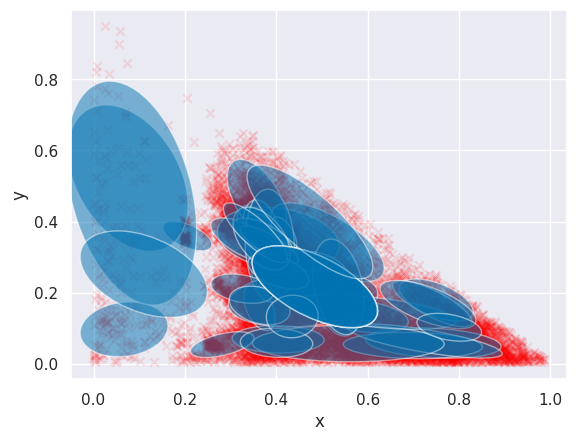

In [16]:
import numpy as np
# colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax, i, j):
    # for n, color in enumerate(colors):
    for cov, means, weight in zip(gmm.covariances_, gmm.means_, gmm.weights_):
        # if weight <= 0.01:
        #     continue
        
        cov = extract_covariance(cov, i, j)
        means = means[[i, j]]

        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])

        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees

        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            means, v[0], v[1], angle=180 + angle,  # color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        # ax.set_aspect("equal", "datalim")


fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(X_train[:, 0], X_train[:, 1], alpha=0.1, color="red", marker="x")
ax.set_xlabel("x")
ax.set_ylabel("y")

make_ellipses(gmm, ax, 0, 1)

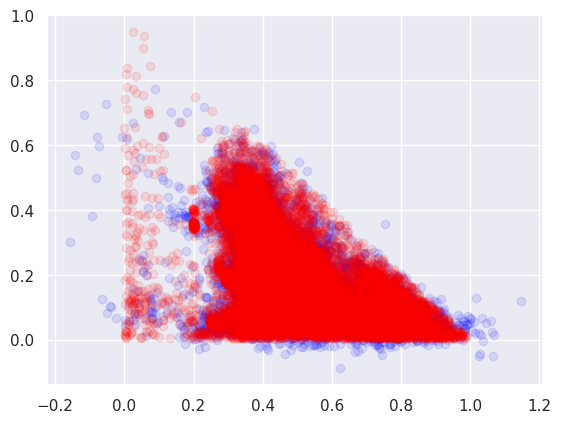

In [17]:
X_gen, _ = gmm.sample(10000)

plt.scatter(X_gen[:, 0], X_gen[:, 1], color="blue", alpha=0.1)
plt.scatter(X_train[:, 0], X_train[:, 1], color="red", marker="o", alpha=0.1)

In [18]:
import seaborn as sns

def plot_kde(season: str, X_gen, X_train):
    fig, axes = plt.subplots(
        nrows=1, ncols=3, figsize=(18, 6), tight_layout=True)
    fig.suptitle(season)

    for i, value in enumerate(["arrival", "duration", "demand"]):
        ax = sns.kdeplot(X_gen[:, i], label="generated", fill=True, ax=axes[i])
        ax = sns.kdeplot(
            X_train[:, i], label="training", fill=True, ax=axes[i])

        # ax.set_aspect("equal", "datalim")
        ax.set_ylim(bottom=0)
        ax.set_xlim(-2, 2)

        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.set_title(value)
        ax.legend()

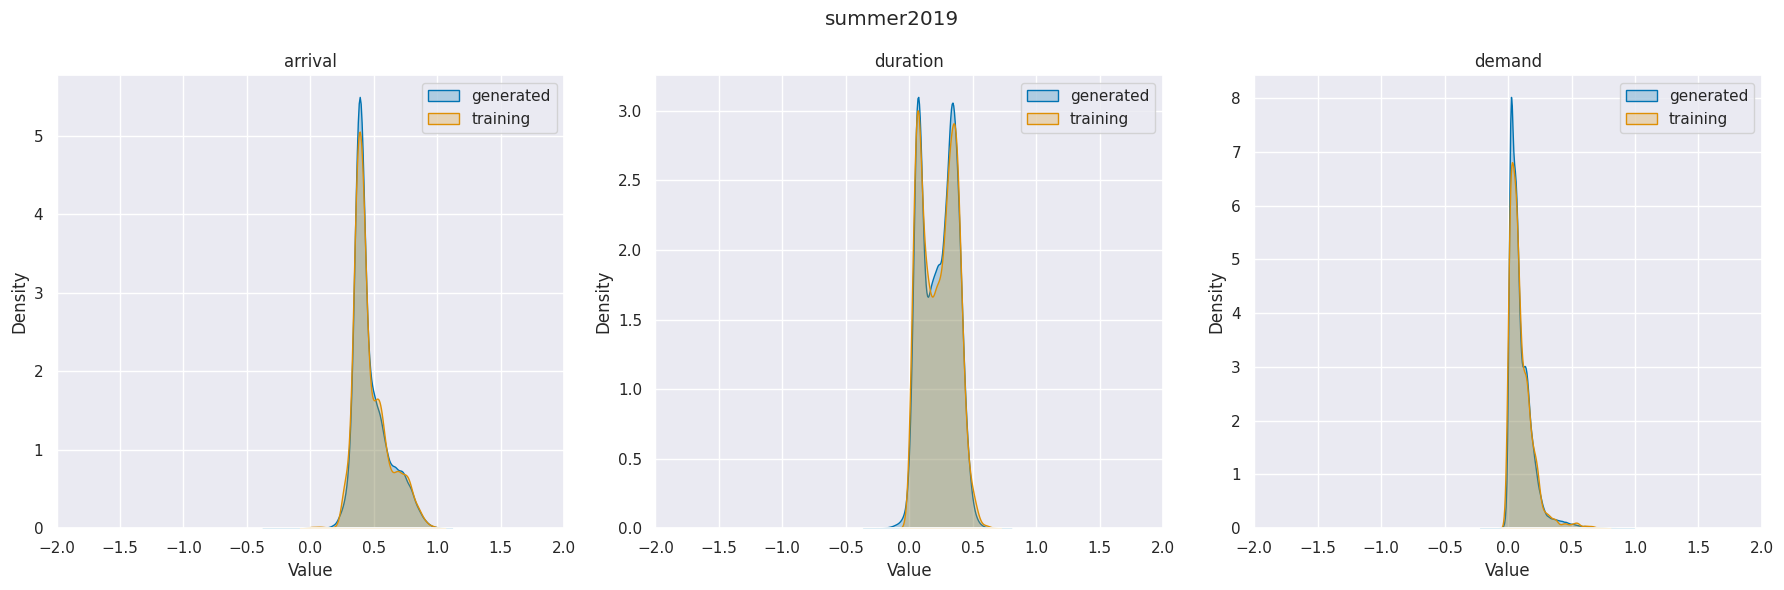

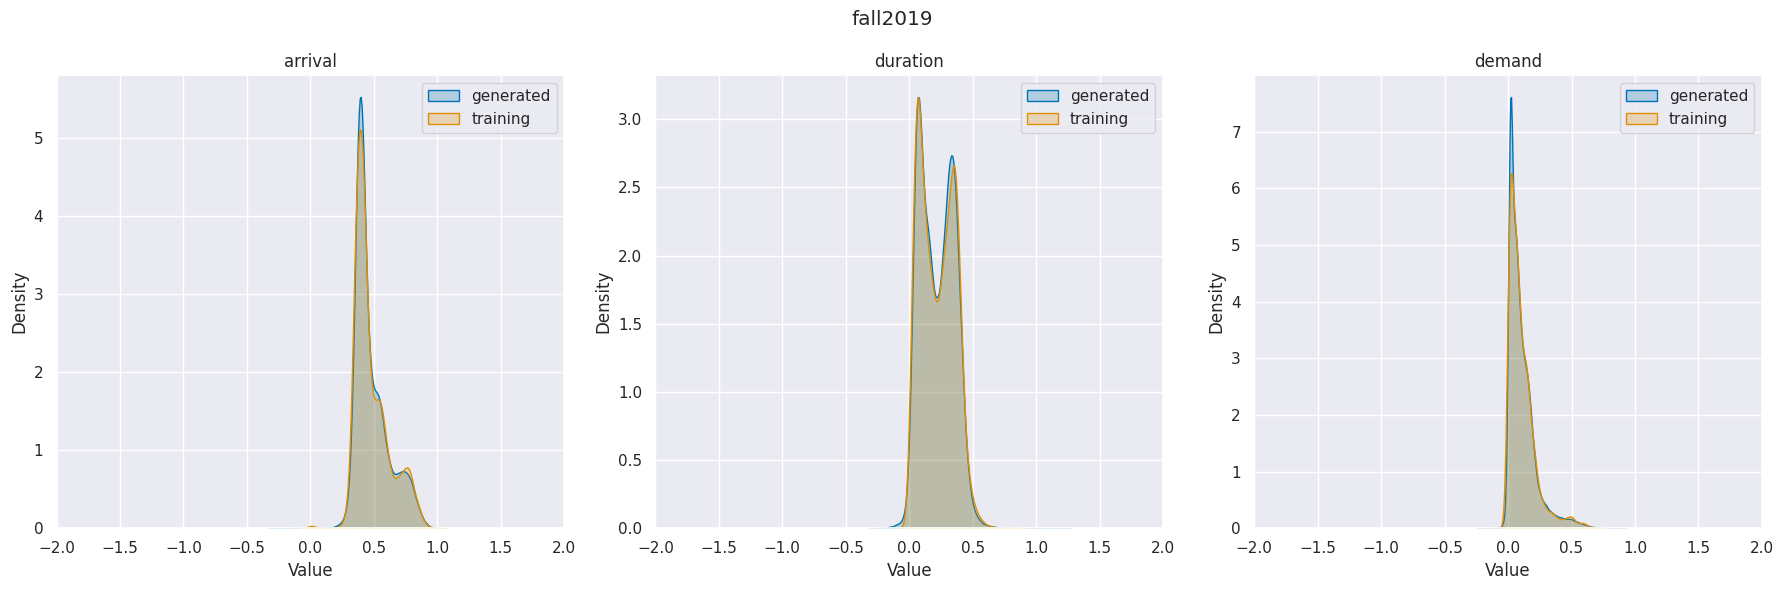

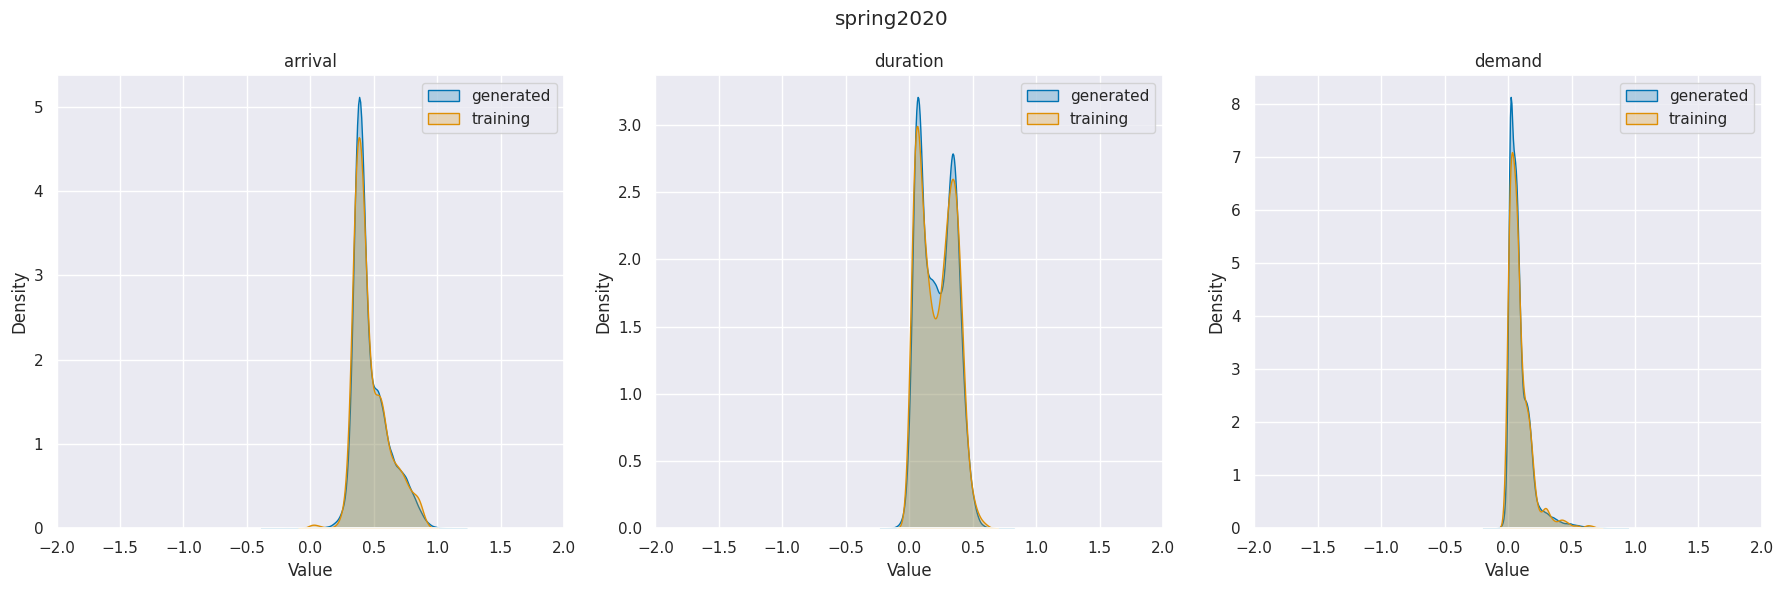

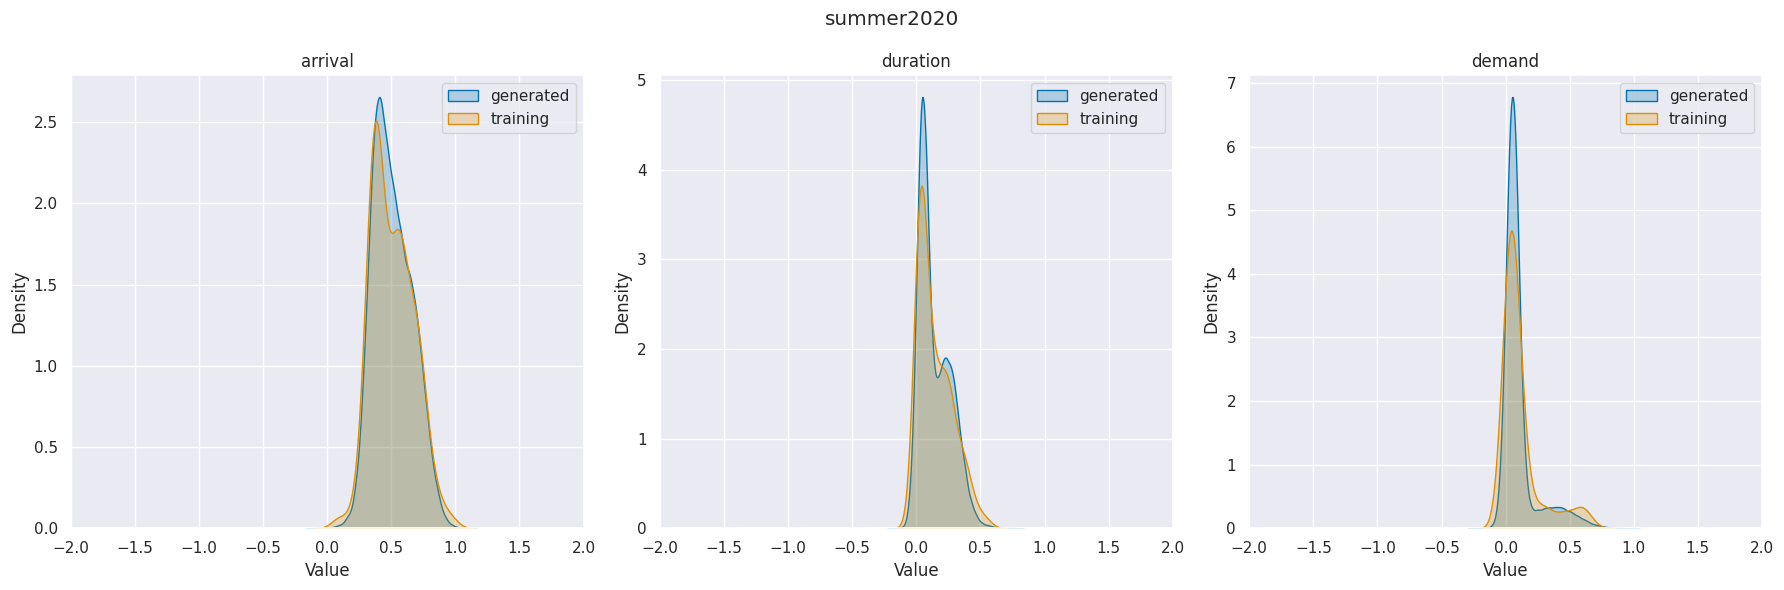

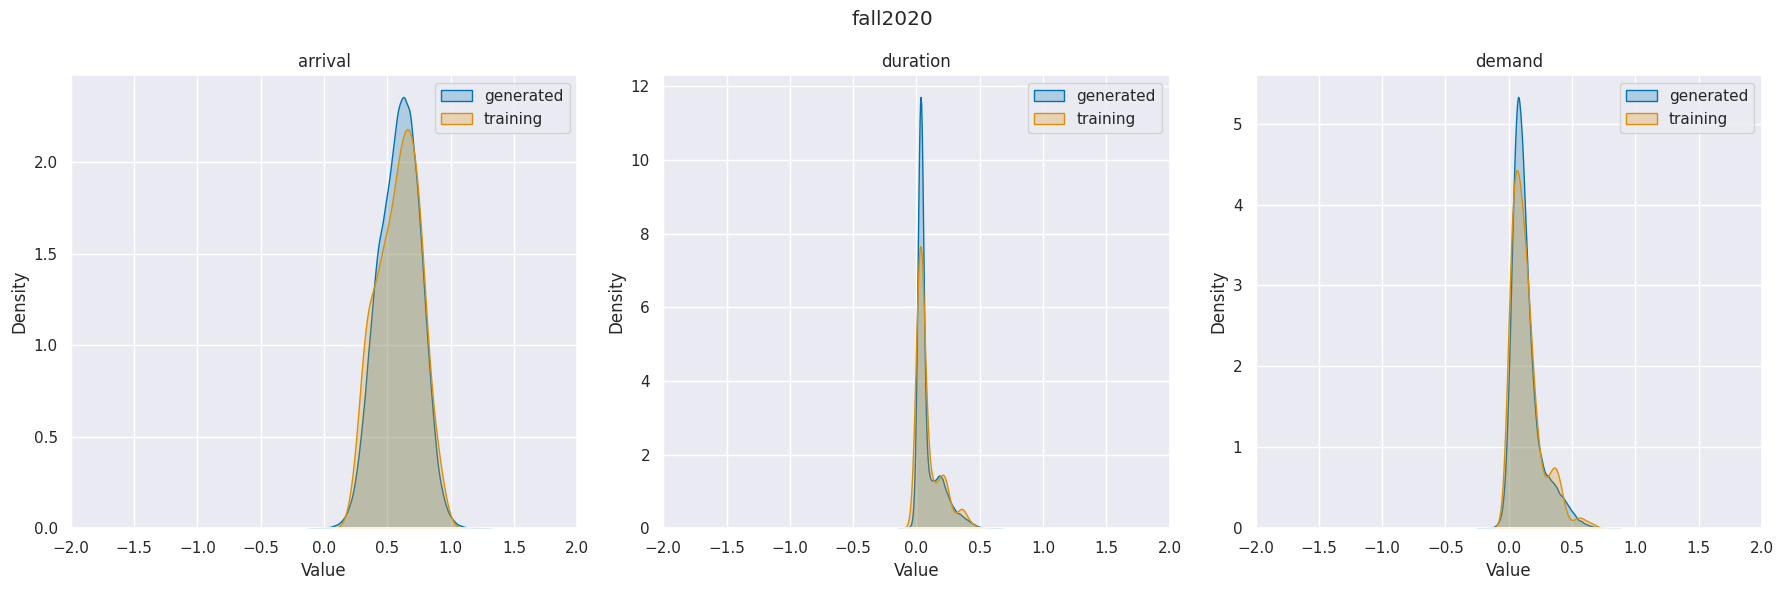

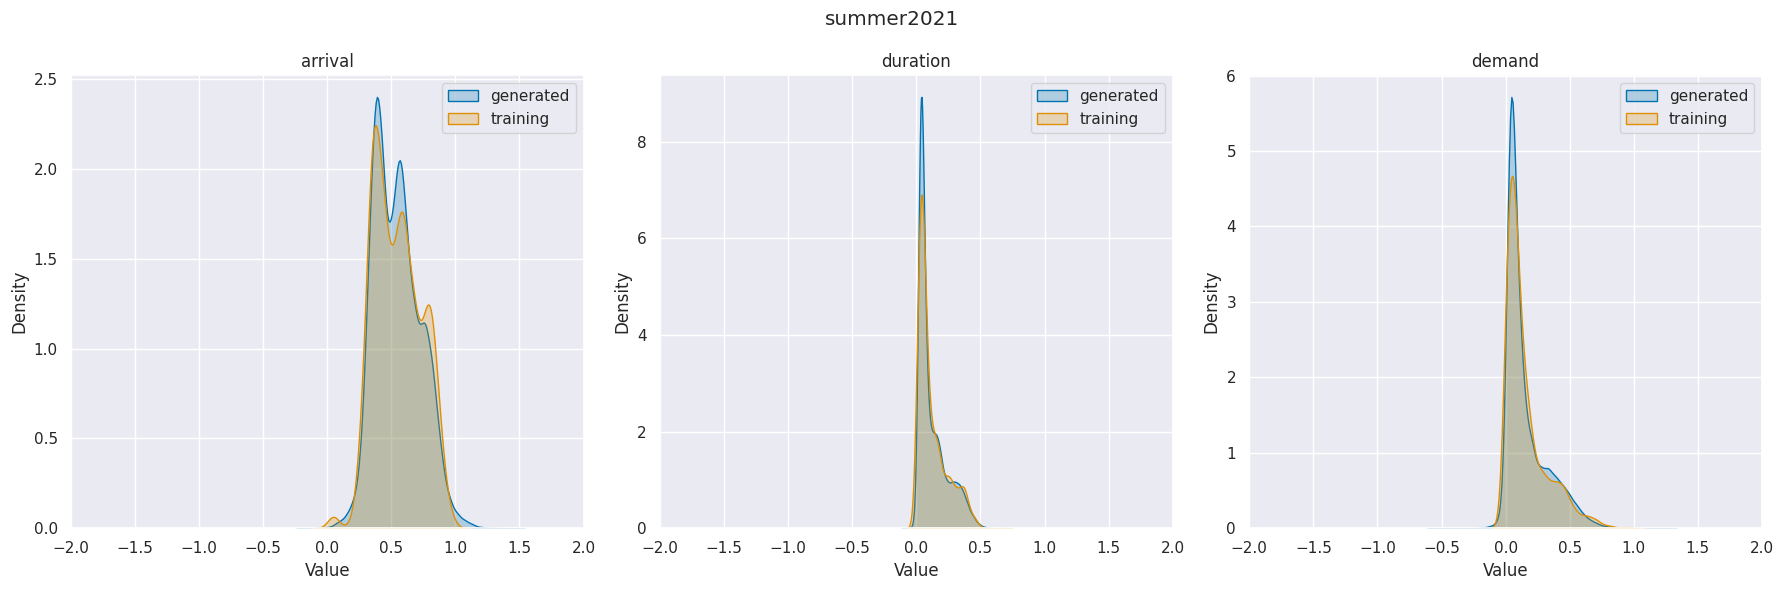

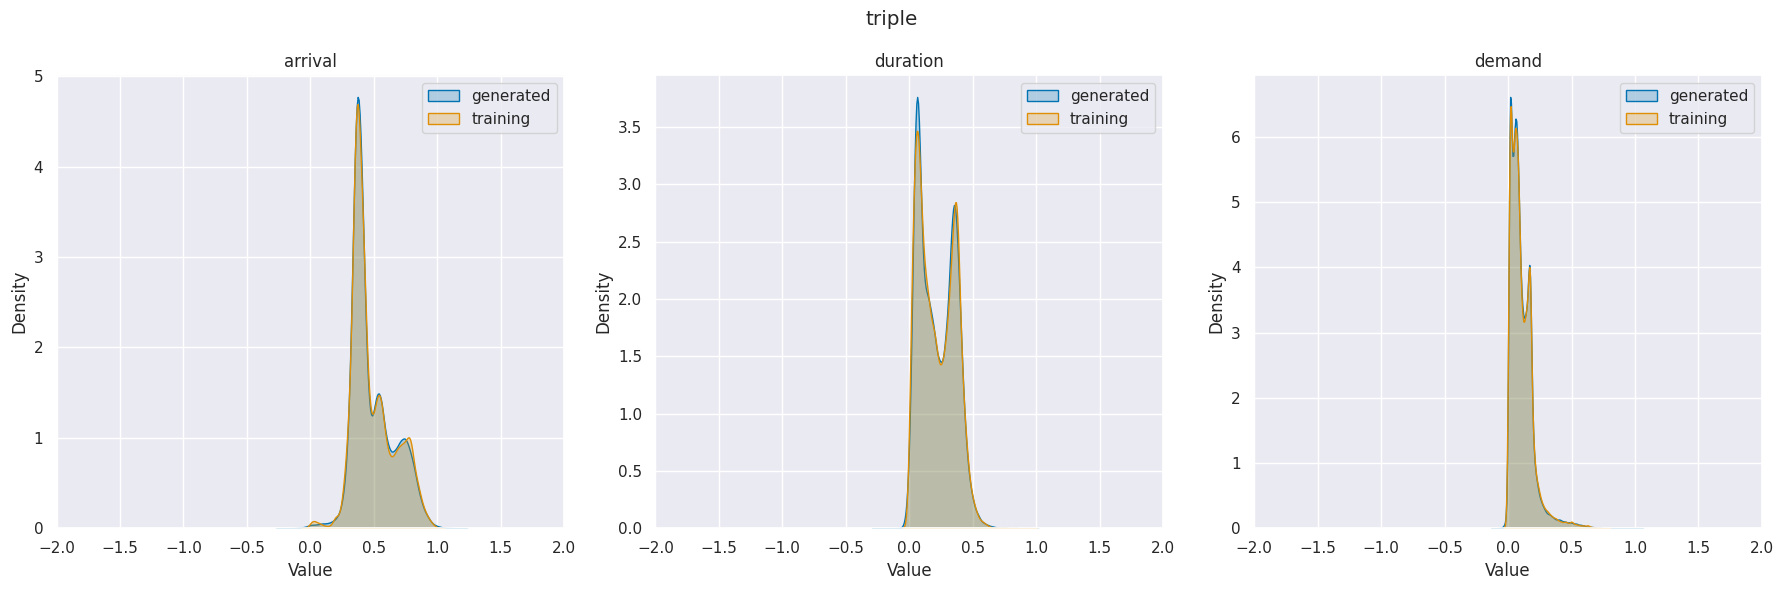

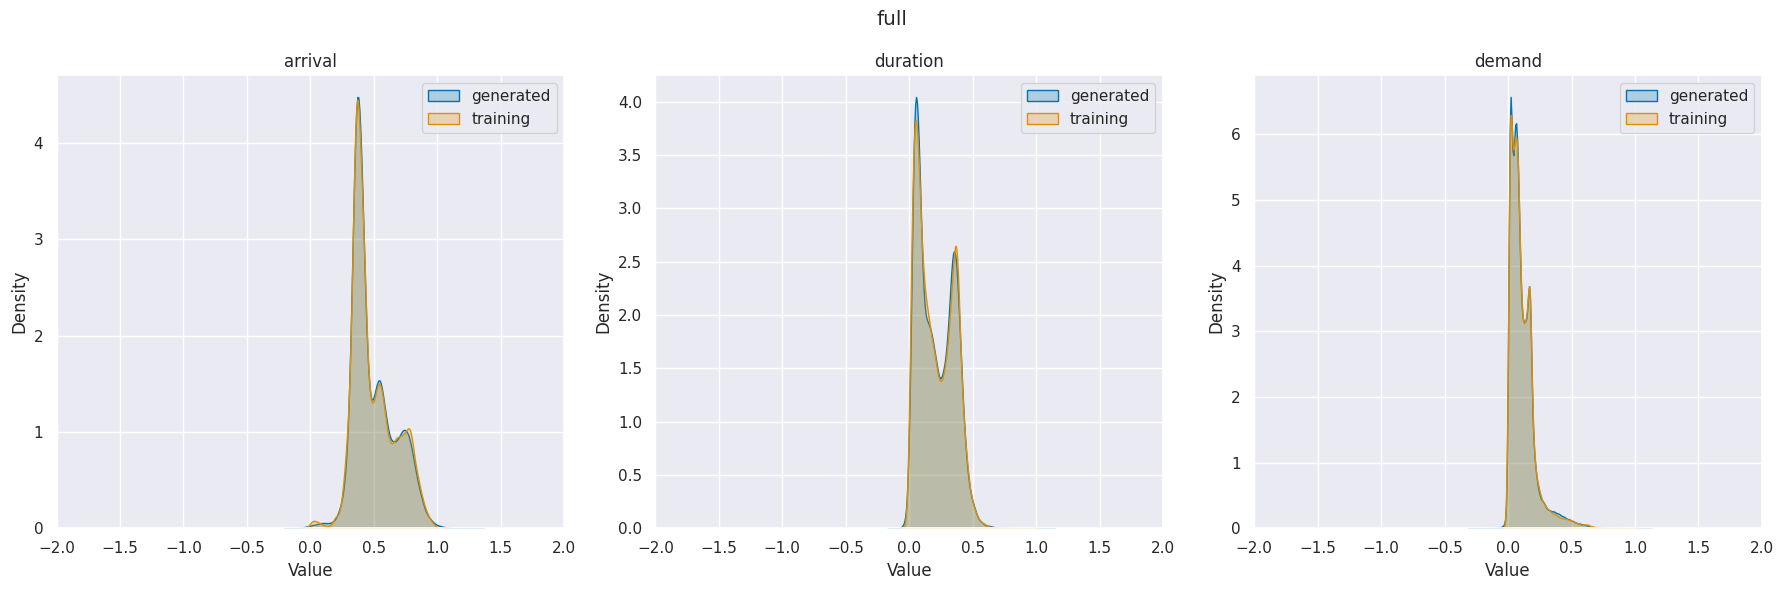

In [19]:
for season in data.keys():
    X_gen, _ = gmms[season][0].sample(100000) 
    X_train = gmms[season][1].transform(data[season])

    plot_kde(season, X_gen, X_train)

In [20]:
# from itertools import product
# import scipy

# results = {}
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), tight_layout=True)

# for i, feature in enumerate(["arrival", "departure", "demand"]):
#     # results[feature] = {}
#     results = {}
#     for (season_a, X_a), (season_b, X_b) in product(data.items(), data.items()):
#         v = scipy.stats.ks_2samp(X_a[:, i], X_b[:, i], method="exact").pvalue
#         # results[feature][f"{season_a} vs {season_b}"] = v
#         results.setdefault(season_a, {})

#         results[season_a][season_b] = v

#     # , columns=results.keys())
#     df = pd.DataFrame.from_dict(results, orient='index')
#     sns.heatmap(df, annot=True, ax=axes[i], fmt=".2g",cmap="coolwarm_r", square=False)

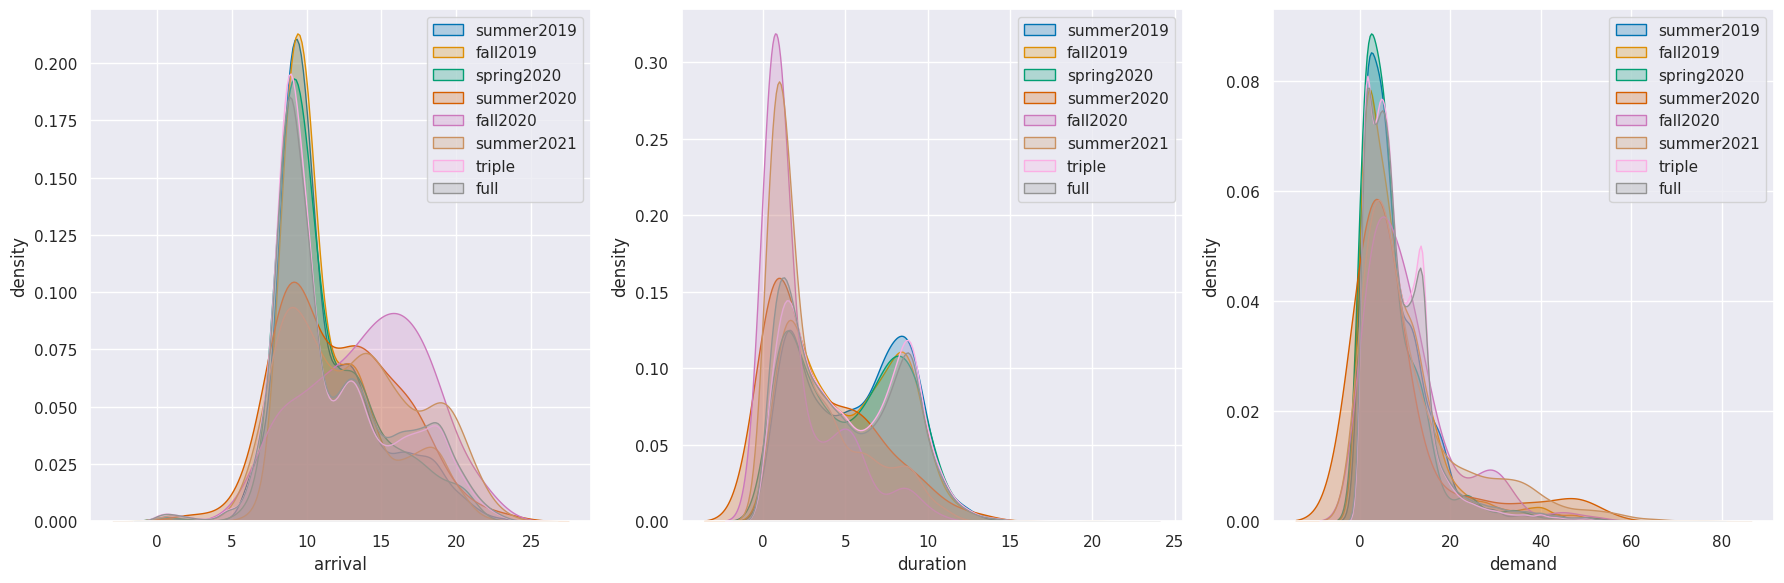

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), tight_layout=True)

for i, feature in enumerate(["arrival", "duration", "demand"]):
    ax = axes[i]
    for season, X in data.items():
        sns.kdeplot(X[:, i], label=season, fill=True, ax=ax)
        
    ax.set_xlabel(feature)
    ax.set_ylabel("density")
    ax.legend()

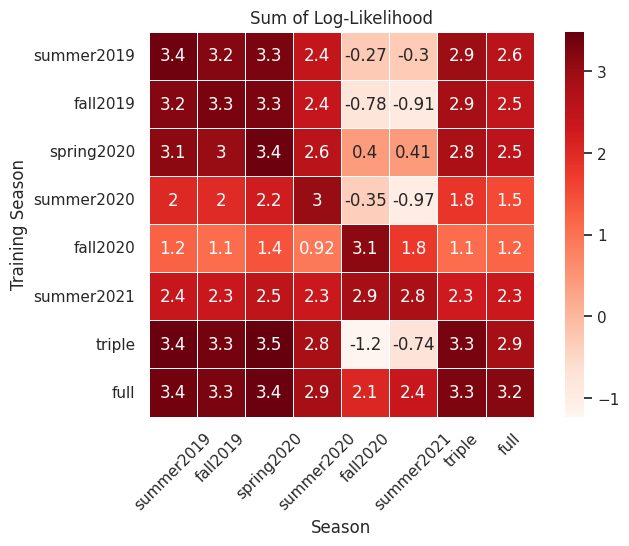

In [22]:
from matplotlib.colors import LogNorm, PowerNorm


results = {}
for key, (gmm, scaler) in gmms.items():
    results[key] = {}  # Each GMM gets a dictionary for seasons
    for season in data.keys():
        X = data[season]
        X = scaler.transform(X)
        # results[key][season] = np.exp(gmm.score(X))
        results[key][season] = gmm.score(X)


df = pd.DataFrame.from_dict(results, orient='index', columns=results.keys())

plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, cmap="Reds", linewidths=0.5, fmt=".2g", square=True,)
            # norm=PowerNorm(gamma=np.e), cbar_kws={"ticks": [0, 1, 2, 3, 3.4]})
plt.title("Sum of Log-Likelihood")
plt.xlabel("Season")
plt.ylabel("Training Season")
plt.xticks(rotation=45)
plt.show()

In [23]:
# try:
#     with open("triple_gmm.pkl", "rb") as f:
#         triple = pickle.load(f)
# except FileNotFoundError:
# gmms = {
#     key: get_gmm(X_train) for key, X_train in data.items()
# }
with open("triple_gmm+sc.pkl", "wb") as f:
    pickle.dump(gmms["triple"], f)